In [130]:
import pandas as pd
import numpy as np

from plotly.express import scatter_3d
from seaborn import histplot, boxplot, countplot, heatmap
from matplotlib.pyplot import plot, show

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split 

from pickle import dump 

In [131]:
path = 'diabetes.csv'
df = pd.read_csv(path, usecols=['Outcome', 'Glucose', 'BMI', 'Age'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Glucose  768 non-null    int64  
 1   BMI      768 non-null    float64
 2   Age      768 non-null    int64  
 3   Outcome  768 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 24.1 KB


In [132]:
# Imputación de los valores 0 
for feature in df.columns:
  if feature == 'Outcome':
    continue
  df[feature] = df[feature].replace({0: df[feature].mean() if feature == 'BMI' else df[feature].median()})

# EDA

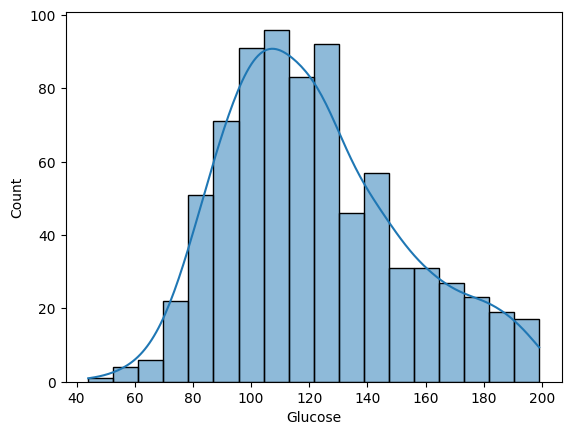

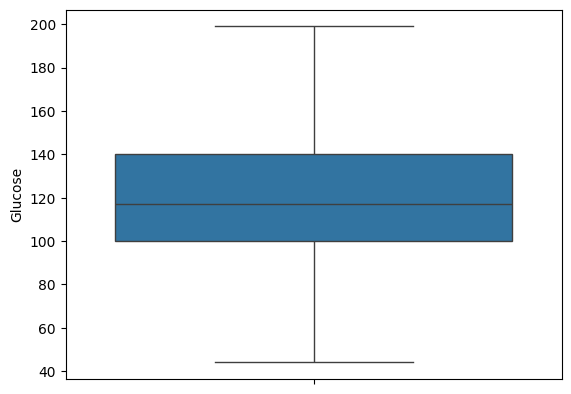

In [133]:
histplot(df['Glucose'], kde=True)
show()
boxplot(df['Glucose'])
show()

Para la 'Glucosa' se observa una distribución de los datos algo sesgada hacia la izquierda.

Con respecto a los *outliers*, no se observa la presencia de ninguno acorde con el diagrama de caja y bigote representado arriba. 

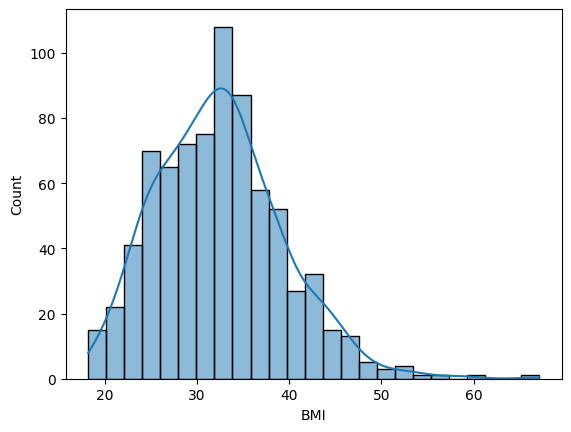

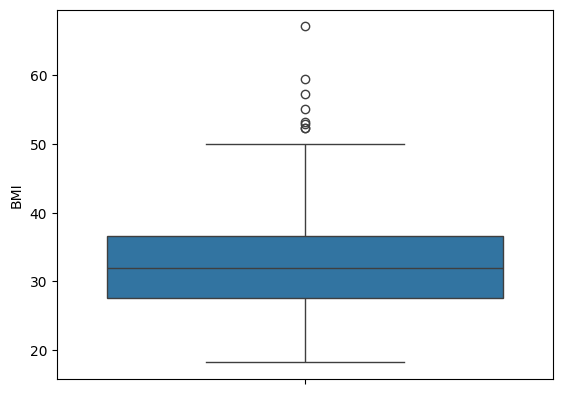

In [134]:
histplot(df['BMI'], kde=True)
show()
boxplot(df['BMI'])
show()

Para el caso del 'BMI' se observa claramente que los datos están sesgados hacia la izquierda. 

El sesgo se puede explicar fácilmente por la presencia de *outliers* hacia el **límite superior** de los datos, cosa que se observa tanto en el diagrama de caja y bigote como el histograma de la parte superior. 

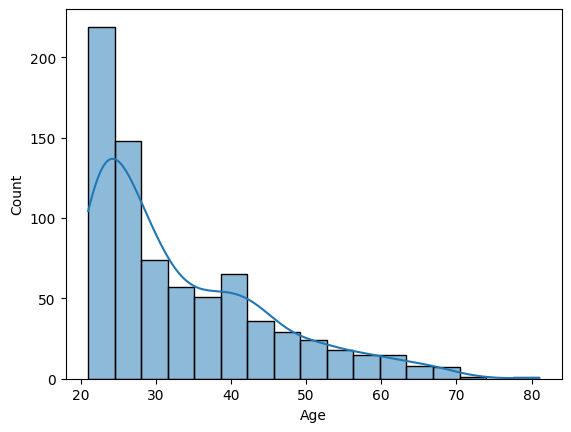

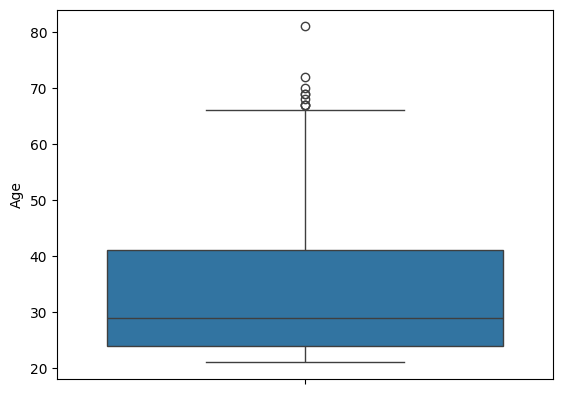

In [135]:
histplot(df['Age'], kde=True)
show()
boxplot(df['Age'])
show()

Para el último caso, de la característica 'Age' el sesgo de los datos hacia la izquierda está muy marcado por la **presencia de varios outliers** en el **límite superior**. 

Particularmente, tanto en el histograma como en el diagrama de caja y bigote se observa 1 valor atípico más marcado que el resto. 

Para finalizar con el EDA, voy a tomar una pequeña muestra de los datos para pintar un diagrama de dispersión tridimensional acorde con las características con las que vamos a entrenar el modelo de clasificación utilizando un algoritmo CART. 

In [136]:
df_sample = df.iloc[:50]
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Glucose  50 non-null     int64  
 1   BMI      50 non-null     float64
 2   Age      50 non-null     int64  
 3   Outcome  50 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 1.7 KB


In [137]:
scatter_3d(data_frame=df_sample, 
           x='Glucose', 
           y='Age', 
           z='BMI', 
           color=['enfermo' if ill else 'sano' for ill in df_sample['Outcome']],
           color_discrete_sequence=['#ff0000' if ill else '#00ff00' for ill in df_sample['Outcome']])

Por último, voy a analizar el balance de registros de para las clases de este set de datos, que son **enfermo** y **sano**.

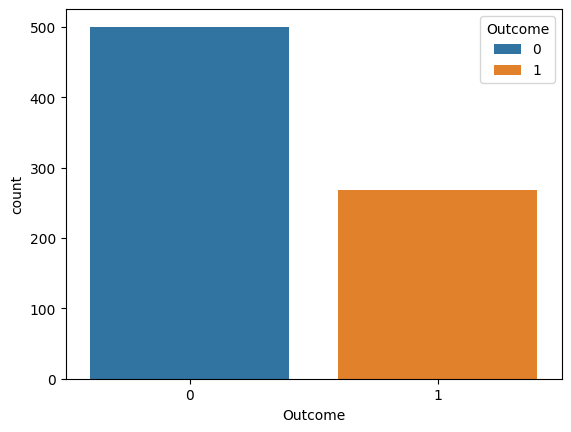

In [138]:
countplot(df, x="Outcome", hue="Outcome")
show()

Como se puede observar, claramente el número de pacientes sanos es mucho mayor que el número de pacientes enfermos, puesto que es mucho más común. 

Ahora que ya está finalizado el análisis exploratorio de los datos, vamos a entrenar e investigar los algoritmos CART que ofrece la librería sklearn.

In [139]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [140]:
gini_classifier = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
entropy_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=3, class_weight='balanced')

gini_classifier.fit(X_train, y_train)
entropy_classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3)

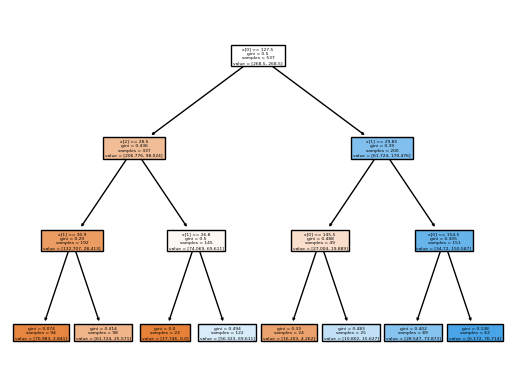

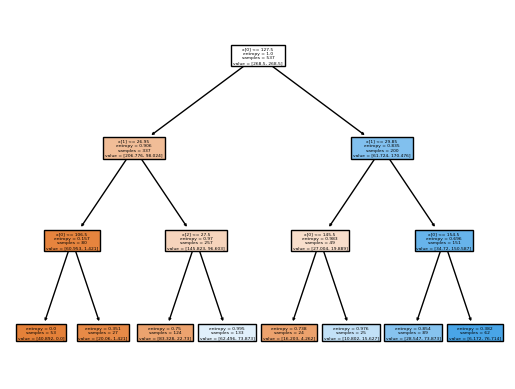

In [141]:
plot_tree(gini_classifier, filled=True)
show()
plot_tree(entropy_classifier, filled=True)
show()

En este caso, cada nodo se encuentra coloreado con una intensidad acorde a la clase dominante en cada subdivisión. En ambos árboles los nodos terminales o nodos "hoja" son bastante similares, salvando quizá que hay algo más de pureza en los nodos terminales del **árbol de arriba** (*el que utiliza como criterio el índice Gini*).

Al comparar su rendimiento utilizando las métricas de evaluación pertinentes para modelos de clasificación, se observará mucho mejor cuál de los dos clasificadores rinde mejor con el conjunto de datos de prueba. 

----------------- GINI TREE EVALUATION -----------------


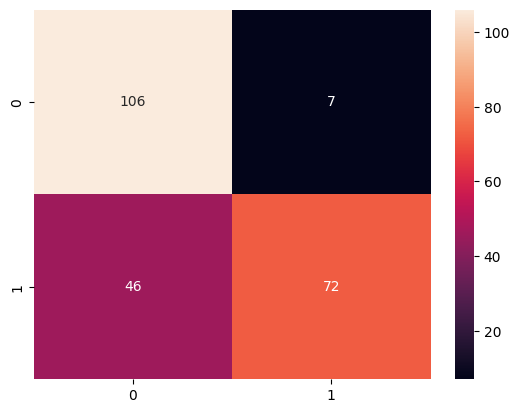

Classifier accuracy: 0.77
Classifier precission: 0.91
Classifier recall: 0.61
Classifier f1_score: 0.73


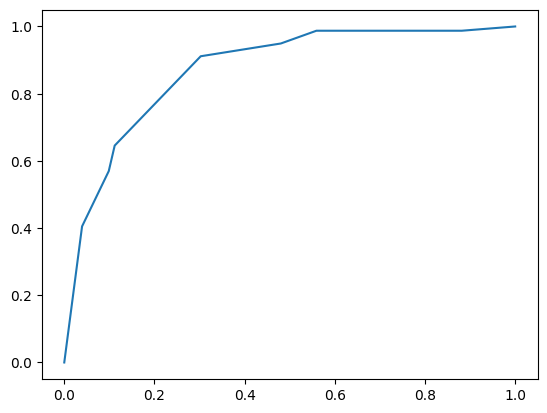

Classifier AUC score: 0.87


In [142]:
print('----------------- GINI TREE EVALUATION -----------------')
y_pred = gini_classifier.predict(X_test)
score = gini_classifier.predict_proba(X_test)[:, 1]

heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='.0f')
show()

print(f'Classifier accuracy: {accuracy_score(y_pred, y_test):.2f}')
print(f'Classifier precission: {precision_score(y_pred, y_test, pos_label=1):.2f}')
print(f'Classifier recall: {recall_score(y_pred, y_test, pos_label=1):.2f}')
print(f'Classifier f1_score: {f1_score(y_pred, y_test, pos_label=1):.2f}')

fpr, tpr, _ = roc_curve(y_test, score)
plot(fpr, tpr)
show()

print(f'Classifier AUC score: {roc_auc_score(y_test, score):.2f}')

----------------- ENTROPY TREE EVALUATION -----------------


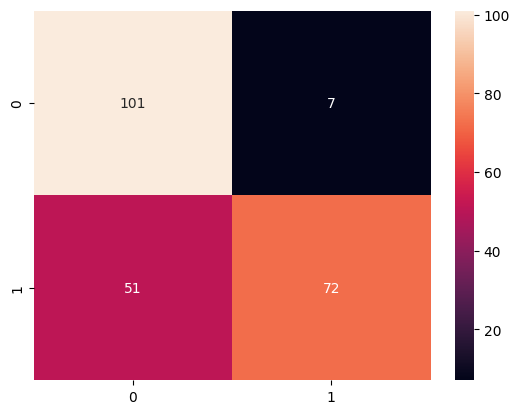

Classifier accuracy: 0.75
Classifier precission: 0.91
Classifier recall: 0.59
Classifier f1_score: 0.71


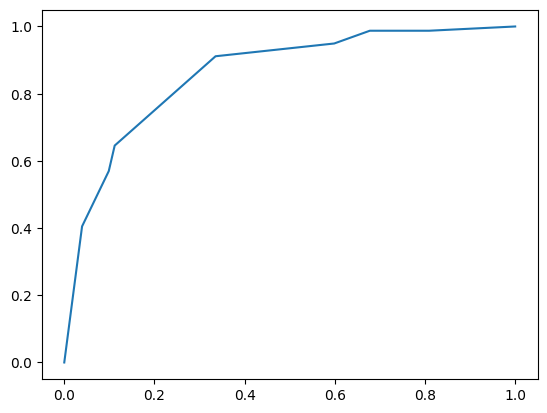

Classifier AUC score: 0.86


In [143]:
print('----------------- ENTROPY TREE EVALUATION -----------------')
y_pred = entropy_classifier.predict(X_test)
score = entropy_classifier.predict_proba(X_test)[:, 1]

heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='.0f')
show()

print(f'Classifier accuracy: {accuracy_score(y_pred, y_test):.2f}')
print(f'Classifier precission: {precision_score(y_pred, y_test, pos_label=1):.2f}')
print(f'Classifier recall: {recall_score(y_pred, y_test, pos_label=1):.2f}')
print(f'Classifier f1_score: {f1_score(y_pred, y_test, pos_label=1):.2f}')

fpr, tpr, _ = roc_curve(y_test, score)
plot(fpr, tpr)
show()

print(f'Classifier AUC score: {roc_auc_score(y_test, score):.2f}')

Como confirman las métricas de evaluación, el modelo que ha utilizado como criterio de sudivisión el **índice Gini** tiene un **mejor rendimiento** que el **que** ha utilizado la **entropía**.

Por último, falta serializarlo para poder implementarlo en la aplicación web que predice si un paciente estará enfermo de diabetes o no en función de sus características.

In [144]:
dump(gini_classifier, open('./tree-classifier.pkl', 'wb'))